In [1]:
pip install transformers datasets evaluate accelerate peft scikit-learn matplotlib wandb


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from transformers import RobertaModel, RobertaTokenizer, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from peft import LoraConfig, get_peft_model
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import evaluate
import json
import numpy as np
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

In [2]:
def construct_dataset(): 
    with open('datasets/binary_classifier_sample.json', 'r') as f:
        data = json.load(f)
    
    entries = data['data']
    for entry in entries:
        entry['label'] = int(entry.pop('error'))
        entry['text'] = entry.pop('code_sample')
    df = pd.DataFrame(entries)
    dataset = Dataset.from_pandas(df)

    train_testvalid = dataset.train_test_split(test_size=0.3, shuffle=True)
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5, shuffle=True)

    dataset = DatasetDict({
        'train': train_testvalid['train'],
        'validation': test_valid['train'],
        'test': test_valid['test']
    })

    return dataset

In [3]:
def construct_dataset_from_general(): 
    with open('datasets/dataset_general.jsonl', 'r') as f:
        json_list = list(f)

    with open('datasets/dataset_general_add.jsonl', 'r') as f2:
        json_list_additional = list(f2)

    entries = []
    distinct_code_samples = set()
    for json_str in json_list:
        json_str = json.loads(json_str)

        if json_str['code_with_error']: 
            entry = {}
            entry['text'] = json_str['code_with_error']
            entry['label'] = 1
            entries.append(entry)
            distinct_code_samples.add(entry['text'])

        if json_str['code_without_error']: 
            entry = {}
            entry['text'] = json_str['code_without_error']
            entry['label'] = 0
            entries.append(entry)
            distinct_code_samples.add(entry['text'])

    for json_str in json_list_additional:
        json_str = json.loads(json_str)

        if json_str['code_with_error']: 
            if not json_str['code_with_error'] in distinct_code_samples:
                entry = {}
                entry['text'] = json_str['code_with_error']
                entry['label'] = 1
                entries.append(entry)
                distinct_code_samples.add(entry['text'])

        if json_str['code_without_error']: 
            if not json_str['code_without_error'] in distinct_code_samples:
                entry = {}
                entry['text'] = json_str['code_without_error']
                entry['label'] = 0
                entries.append(entry)
                distinct_code_samples.add(entry['text'])
    
    dataset = Dataset.from_list(entries)

    dataset_copy = Dataset.from_list(entries)
    dataset_copy.set_format(type='pandas')
    df = dataset_copy[:].sample(frac = 1)
    
    code_no_error_cnt = len(df[df['label']==0])
    code_with_error_cnt = len(df[df['label']==1])
    sample_count_normalized = min(code_with_error_cnt, code_no_error_cnt)
    
    positive_samples = df[df['label']==0][:sample_count_normalized]
    negative_samples = df[df['label']==1][:sample_count_normalized]
    
    dataset = Dataset.from_pandas(pd.concat([positive_samples, negative_samples]))
    dataset = dataset.remove_columns('__index_level_0__')

    train_testvalid = dataset.train_test_split(test_size=0.3, shuffle=True)
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5, shuffle=True)

    dataset = DatasetDict({
        'train': train_testvalid['train'],
        'validation': test_valid['train'],
        'test': test_valid['test']
    })

    return dataset

In [4]:
dataset = construct_dataset_from_general()
dataset 

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 170
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 37
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 37
    })
})

# Tokenize

In [5]:
MAX_LEN = 512
peft_model_name = 'roberta-base-peft'
modified_base = 'roberta-base-modified'
roberta_base_model = 'roberta-base'

In [6]:
# Mistral and LLaMMa checkpoints
mistral_checkpoint = "mistralai/Mistral-7B-v0.1"
llama_checkpoint = "codellama/CodeLlama-7b-hf"

In [7]:
def tokenize(dataset, tokenizer): 
    def preprocess(examples):
        return tokenizer(examples.pop('text'), truncation=True, padding=True, max_length=MAX_LEN)
    
    train_dataset = dataset['train'].map(preprocess, batched=True)
    test_dataset = dataset['test'].map(preprocess, batched=True)
    validation_dataset = dataset['validation'].map(preprocess, batched=True)

    return [train_dataset, test_dataset, validation_dataset]

# Same Training Args for both models

In [8]:
def get_trainer(model, train_dataset, eval_dataset, data_collator):
    training_args = TrainingArguments(
        output_dir='./results',
        eval_strategy="epoch",
        learning_rate=5e-4,
        logging_steps=10,
        num_train_epochs=6,
        per_device_train_batch_size=8,
    )
    
    return Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
    )

# Model Evaluation

In [9]:
metric = evaluate.load('accuracy')

def evaluate_model(inference_model, dataset, data_collator):
    eval_dataloader = DataLoader(dataset.rename_column("label", "labels"), batch_size=8, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()
    
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch.to(device)
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        predictions, references = predictions, batch["labels"]
        metric.add_batch(
            predictions=predictions,
            references=references,
        )

    eval_metric = metric.compute()
    print(eval_metric)

# Tokenize dataset

In [10]:
# Roberta
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_base_model)
data_collator_roberta = DataCollatorWithPadding(tokenizer=roberta_tokenizer)
[train_dataset_roberta, test_dataset_roberta, validation_dataset_roberta] = tokenize(dataset, roberta_tokenizer)

# Baseline model
baseline_model = AutoModelForSequenceClassification.from_pretrained(roberta_base_model, num_labels=2)

Map:   0%|          | 0/170 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Llama
llama_tokenizer = AutoTokenizer.from_pretrained(llama_checkpoint, add_prefix_space=True)
llama_tokenizer.pad_token_id = llama_tokenizer.eos_token_id
llama_tokenizer.pad_token = llama_tokenizer.eos_token

data_collator_llama = DataCollatorWithPadding(tokenizer=llama_tokenizer)
[train_dataset_llama, test_dataset_llama, validation_dataset_llama] = tokenize(dataset, llama_tokenizer)

Map:   0%|          | 0/170 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

## Default Roberta Fine-tuning

In [60]:
full_finetuning_trainer_roberta = get_trainer(
    AutoModelForSequenceClassification.from_pretrained(roberta_base_model, num_labels=2).cuda(), 
    train_dataset_roberta, 
    validation_dataset_roberta, 
    data_collator_roberta
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
full_finetuning_trainer_roberta.train()

Epoch,Training Loss,Validation Loss
1,0.826200,0.706675
2,0.695100,0.702294
3,0.739600,0.727882
4,0.689800,0.697582
5,0.684200,0.694653
6,0.693100,0.693782


TrainOutput(global_step=132, training_loss=0.7394965200713186, metrics={'train_runtime': 22.3261, 'train_samples_per_second': 45.686, 'train_steps_per_second': 5.912, 'total_flos': 268373276467200.0, 'train_loss': 0.7394965200713186, 'epoch': 6.0})

## PEFT LORA Training

In [63]:
model_roberta = AutoModelForSequenceClassification.from_pretrained(roberta_base_model, num_labels=2)

peft_config_roberta = LoraConfig(
    task_type="SEQ_CLS", 
    inference_mode=False, 
    r=8, 
    lora_alpha=16, 
    lora_dropout=0.1
)
peft_model_roberta = get_peft_model(model_roberta, peft_config_roberta)

print('PEFT Model')
peft_model_roberta.print_trainable_parameters()
peft_lora_finetuning_trainer_roberta = get_trainer(
    peft_model_roberta,
    train_dataset_roberta, 
    validation_dataset_roberta, 
    data_collator_roberta
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT Model
trainable params: 887,042 || all params: 125,534,212 || trainable%: 0.7066


In [64]:
peft_lora_finetuning_trainer_roberta.train()
peft_lora_finetuning_trainer_roberta.evaluate()

Epoch,Training Loss,Validation Loss
1,0.705100,0.768271
2,0.564400,0.733856
3,0.647300,0.762186
4,0.530800,0.629055
5,0.437000,0.667433
6,0.521300,0.675248


{'eval_loss': 0.6752476692199707,
 'eval_runtime': 0.2717,
 'eval_samples_per_second': 136.166,
 'eval_steps_per_second': 18.401,
 'epoch': 6.0}

## Llama Lora fine tuning 

In [12]:
from transformers import AutoModelForSequenceClassification
import torch
llama_model = AutoModelForSequenceClassification.from_pretrained(
  pretrained_model_name_or_path=llama_checkpoint,
  num_labels=2,
)
llama_model = llama_model.cuda()
llama_model.config.pad_token_id = llama_model.config.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at codellama/CodeLlama-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
print("Llama before fine-tuning")
evaluate_model(llama_model, test_dataset_llama, data_collator_llama)

Llama before fine-tuning


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]

{'accuracy': 0.4864864864864865}


In [13]:
from peft import get_peft_model, LoraConfig, TaskType
llama_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=16, lora_alpha=16, lora_dropout=0.05, bias="none", 
    target_modules=[
        "q_proj",
        "v_proj",  
    ],
)

llama_model = get_peft_model(llama_model, llama_peft_config)
llama_model.print_trainable_parameters()

trainable params: 8,396,800 || all params: 6,615,814,144 || trainable%: 0.1269


In [14]:
from transformers import TrainingArguments, Trainer

# Llama
llama_tokenizer = AutoTokenizer.from_pretrained(llama_checkpoint, add_prefix_space=True)
llama_tokenizer.pad_token_id = llama_tokenizer.eos_token_id
llama_tokenizer.pad_token = llama_tokenizer.eos_token

data_collator_llama = DataCollatorWithPadding(tokenizer=llama_tokenizer)
[train_dataset_llama, test_dataset_llama, validation_dataset_llama] = tokenize(dataset, llama_tokenizer)

lr = 1e-4
batch_size = 8
num_epochs = 6
training_args = TrainingArguments(
    eval_strategy="epoch",
    save_strategy="epoch",
    output_dir="./llama-lora-token-classification",
    learning_rate=lr,
    lr_scheduler_type= "constant",
    warmup_ratio= 0.1,
    max_grad_norm= 0.3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.001,
    load_best_model_at_end=True,
    report_to="none",
    fp16=True,
    logging_steps=30
)

llama_trainer = Trainer(
    model=llama_model,
    args=training_args,
    train_dataset=train_dataset_llama,
    eval_dataset=validation_dataset_llama,
    data_collator=data_collator_llama,
    # compute_metrics=compute_metrics
)

Map:   0%|          | 0/170 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

In [15]:
llama_trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.586246
2,0.764400,0.556528
3,0.544100,0.561479
4,0.544100,0.583269
5,0.389600,0.428359
6,0.145700,0.357248


TrainOutput(global_step=132, training_loss=0.4310609246745254, metrics={'train_runtime': 74.3851, 'train_samples_per_second': 13.712, 'train_steps_per_second': 1.775, 'total_flos': 2.031934507057152e+16, 'train_loss': 0.4310609246745254, 'epoch': 6.0})

In [71]:
print("Roberta Full fine-tuning accuracy")
evaluate_model(full_finetuning_trainer_roberta.model, test_dataset_roberta, data_collator_roberta)

print("Roberta Lora fine-tuning")
evaluate_model(peft_lora_finetuning_trainer_roberta.model, test_dataset_roberta, data_collator_roberta)

Roberta Full fine-tuning accuracy


100%|██████████| 5/5 [00:00<00:00, 23.29it/s]


{'accuracy': 0.4594594594594595}
Roberta Lora fine-tuning


100%|██████████| 5/5 [00:00<00:00, 19.38it/s]

{'accuracy': 0.7567567567567568}


In [16]:
print("Llama Lora fine-tuning")
evaluate_model(llama_trainer.model, test_dataset_llama, data_collator_llama)

Llama Lora fine-tuning


100%|██████████| 5/5 [00:00<00:00,  5.15it/s]

{'accuracy': 0.7027027027027027}


In [17]:
print("No fine-tuning accuracy")
evaluate_model(baseline_model, test_dataset_roberta, data_collator_roberta)

No fine-tuning accuracy


100%|██████████| 5/5 [00:00<00:00, 20.76it/s]

{'accuracy': 0.4864864864864865}


In [23]:
import matplotlib.pyplot as plt

def plot_training(trainer): 
    logs = trainer.state.log_history

    train_loss = [log['loss'] for log in logs if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
    steps = [log['step'] for log in logs if 'step' in log]
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(steps[:len(train_loss)], train_loss, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(steps[:len(eval_loss)], eval_loss, label='Evaluation Loss', color='orange')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Evaluation Accuracy Over Time')
    plt.legend()
    
    plt.show()

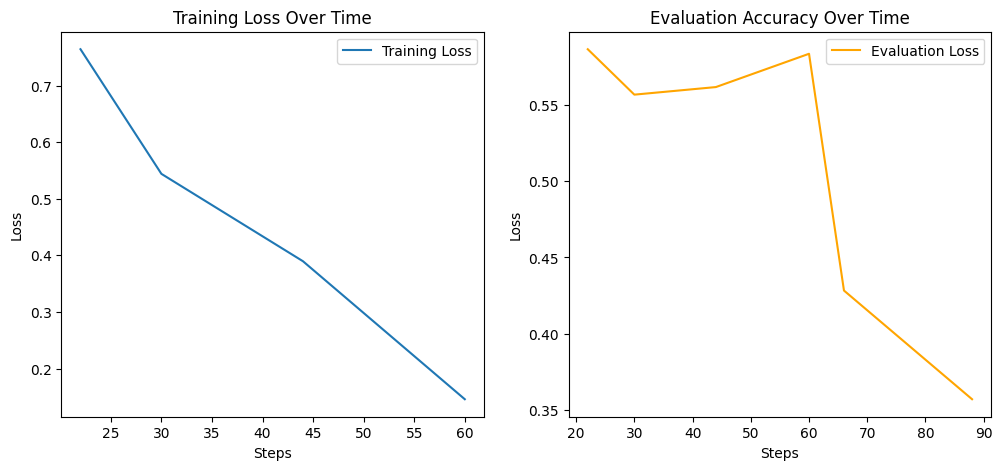

In [24]:
plot_training(llama_trainer)